In [1]:
import torch
import transformers
from transformers import AutoTokenizer
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from lm_eval.models.huggingface import HFLM
from lm_eval.api.model import LM
from lm_eval.api.registry import register_model
import matplotlib.pyplot as plt
def normalize_attn_mat(attn_mat):
    return (attn_mat - torch.min(attn_mat)) / (torch.max(attn_mat) - torch.min(attn_mat))
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

  warnings.warn(
2024-05-10:17:10:47,039 INFO     [utils.py:145] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2024-05-10:17:10:47,040 INFO     [utils.py:148] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-05-10:17:10:47,040 INFO     [utils.py:161] NumExpr defaulting to 8 threads.
2024-05-10:17:10:47,374 INFO     [config.py:58] PyTorch version 2.1.1+cu118 available.


### Define and load a pretrained Mamba-based LLM:

In [2]:
class MambaEvalWrapper(HFLM):
    AUTO_MODEL_CLASS = transformers.AutoModelForCausalLM
    def __init__(self, pretrained="state-spaces/mamba-2.8b", max_length=2048, batch_size=None, device="cuda",dtype=torch.float16):
        LM.__init__(self)
        self._model = MambaLMHeadModel.from_pretrained(pretrained, device=device, dtype=dtype)
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.vocab_size = self.tokenizer.vocab_size
        self._batch_size = int(batch_size) if batch_size is not None else 64
        self._max_length = max_length
        self._device = torch.device(device)

In [3]:
model = MambaEvalWrapper()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
prompt = "Alice was beginning to get very tired of sitting by her sister on the bank"#, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?” So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes"# ran close by her. There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge. In another moment down went Alice after it, never once considering how in the world she was to get out again. The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well. Either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next. First, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps and pictures hung upon pegs. She took down a jar from one of the shelves as she passed; it was labelled “ORANGE MARMALADE”, but to her great disappointment it was empty: she did not like to drop the jar for fear of killing somebody underneath, so managed to put it"

### Extraction of Attention Maps:

In [5]:
input_tensor = model.tokenizer(prompt, return_tensors="pt")['input_ids'].cuda()
selected_chan = [1,2,3,4,5,6,7]
selected_layer = 8
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = True

In [6]:
model._model = model._model.cuda()
out = model._model(input_tensor)

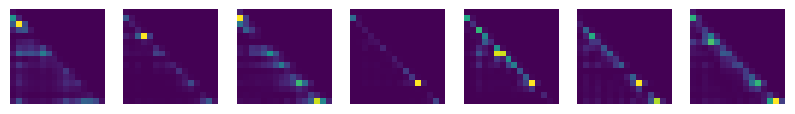

In [7]:
attn_mat = model._model.backbone.layers[selected_layer].mixer.attn_mat
fig, axs = plt.subplots(1, len(selected_chan), figsize=(10,10))
for i,c in enumerate(selected_chan):
    curr_attn_mat = normalize_attn_mat(attn_mat[0,c,:,:].abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False

In [8]:
def save_attention_matrix(attn_matrix, channel_index):
    plt.figure(figsize=(6, 6))  # Create a new figure for the matrix
    plt.imshow(attn_matrix.cpu().detach().numpy(), cmap='viridis')  # Display the matrix using a color map
    plt.axis('off')  # Hide the axes
    #plt.colorbar()  # Optionally add a colorbar to indicate the scale
    filepath = f'MAMBA_attention_map_layer_{selected_layer}_channel_{channel_index}.png'  # Name the file based on the channel index
    plt.savefig(filepath, dpi=300, bbox_inches='tight')  # Save the figure to a file
    plt.close()  # Close the figure to free up memory

for c in range(100):
    curr_attn_mat = normalize_attn_mat(attn_mat[0, c, :, :].abs())
    save_attention_matrix(curr_attn_mat, c)  #

### Extraction of Old Attention Maps:

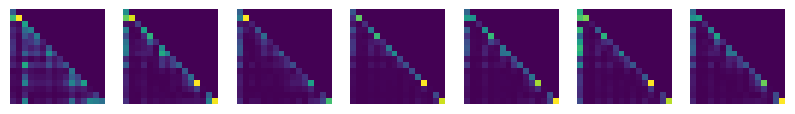

In [9]:
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = True
model._model.backbone.layers[selected_layer].mixer.old_attention = True
model._model = model._model.cuda()
out = model._model(input_tensor)
attn_mat = model._model.backbone.layers[selected_layer].mixer.attn_mat
fig, axs = plt.subplots(1, len(selected_chan), figsize=(10,10))
for i,c in enumerate(selected_chan):
    curr_attn_mat = normalize_attn_mat(attn_mat[0,c,:,:].abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False
model._model.backbone.layers[selected_layer].mixer.old_attention = False

### Extraction of Attention Vecotrs (New Method):

In [25]:
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False
model._model.backbone.layers[selected_layer].mixer.old_attention = False
model._model.backbone.layers[selected_layer].mixer.compute_attn_vector = True
model._model = model._model.cuda()
out = model._model(input_tensor)
attn_vec = model._model.backbone.layers[selected_layer].mixer.attn_vec
fig, axs = plt.subplots(1, len(selected_chan), figsize=(13,len(selected_chan)))
for i,c in enumerate(selected_chan):
    curr_attn_vec = normalize_attn_mat(attn_vec[0,c,:].abs())
    axs[i].imshow(curr_attn_vec.unsqueeze(0).cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False
model._model.backbone.layers[selected_layer].mixer.old_attention = False
model._model.backbone.layers[selected_layer].mixer.compute_attn_vector = False

### Extraction of Attention Vecotrs (Old Method):

In [22]:
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False
model._model.backbone.layers[selected_layer].mixer.old_attention = True
model._model.backbone.layers[selected_layer].mixer.compute_attn_vector = True
model._model = model._model.cuda()
out = model._model(input_tensor)
attn_vec = model._model.backbone.layers[selected_layer].mixer.attn_vec
fig, axs = plt.subplots(1, len(selected_chan), figsize=(13,len(selected_chan)))
for i,c in enumerate(selected_chan):
    curr_attn_vec = normalize_attn_mat(attn_vec[0,c,:].abs())
    axs[i].imshow(curr_attn_vec.unsqueeze(0).cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False
model._model.backbone.layers[selected_layer].mixer.old_attention = False
model._model.backbone.layers[selected_layer].mixer.compute_attn_vector = False

### Ablations visualization:

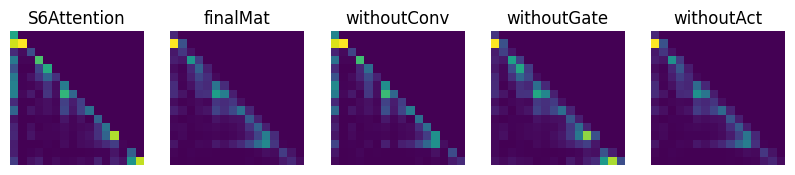

In [12]:
model._model.backbone.layers[selected_layer].mixer.ablate_attn_mat = True
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = True
model._model = model._model.cuda()
out = model._model(input_tensor)
ablate_dict = model._model.backbone.layers[selected_layer].mixer.ablate_dict
ablate_dict = {k:v for k,v in ablate_dict.items() if k in ['S6Attention','finalMat','withoutConv','withoutGate','withoutAct']}
fig, axs = plt.subplots(1, len(ablate_dict), figsize=(10,len(ablate_dict.items())))
for i,c in enumerate(ablate_dict.items()):
    axs[i].set_title(c[0])
    curr_attn_vec = normalize_attn_mat(c[1][0,0,:,:].abs())
    axs[i].imshow(curr_attn_vec.cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.ablate_attn_mat = False
model._model.backbone.layers[selected_layer].mixer.compute_attn_matrix = False

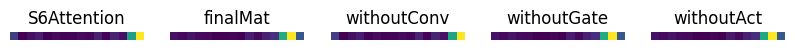

In [16]:
model._model.backbone.layers[selected_layer].mixer.ablate_attn_mat = False
model._model.backbone.layers[selected_layer].mixer.ablate_attn_vec = True
model._model = model._model.cuda()
out = model._model(input_tensor)
ablate_dict = model._model.backbone.layers[selected_layer].mixer.ablate_dict
ablate_dict = {k:v for k,v in ablate_dict.items() if k in ['S6Attention','finalMat','withoutConv','withoutGate','withoutAct']}
fig, axs = plt.subplots(1, len(ablate_dict), figsize=(10,len(ablate_dict.items())))
for i,c in enumerate(ablate_dict.items()):
    axs[i].set_title(c[0])
    curr_attn_vec = normalize_attn_mat(c[1][0,0:1,:].abs())
    axs[i].imshow(curr_attn_vec.cpu().detach().numpy())
    axs[i].axis('off')
model._model.backbone.layers[selected_layer].mixer.ablate_attn_mat = False
model._model.backbone.layers[selected_layer].mixer.ablate_attn_vec = False